In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

#A comparison between different embeddings for Sarcasm Detection

In this work we compare two different embeddings, Word2Vec and BERT, for Sarcasm Detection.

Group:


*   Francesco Stranieri (816551)
*   Francesco Porto (816042)



## Dataset description
We use the **News Headlines Dataset for Sarcasm Detection**, available [here](https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection). This dataset combines news headlines from [TheOnion](https://www.theonion.com/), a sarcastic online journal, and [HuffPost](https://www.huffpost.com/), an actual non-sarcastic journal.

Each record consists of three attributes:



1.   **is_sarcastic**: 1 if the record is sarcastic otherwise 0
2.   **headline**: the headline of the news article
3.   **article_link**: link to the original news article. Useful in collecting supplementary data




In [2]:
# https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection?select=Sarcasm_Headlines_Dataset_v2.json
news_headlines = pd.read_json("Sarcasm_Headlines_Dataset_v2.json", lines=True)
news_headlines.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [3]:
news_headlines.isna().sum()

is_sarcastic    0
headline        0
article_link    0
dtype: int64

We remove the **article_link** column as we will not use it during our analysis.

In [4]:
news_headlines.drop(columns="article_link", inplace=True)
news_headlines.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


The dataset is slightly unbalanced, but we think this will not impact our analysis.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


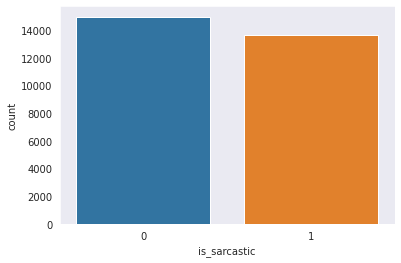

In [5]:
sns.set_style("dark")
sns.countplot(news_headlines['is_sarcastic'])

##Dataset preprocessing
Before feeding our dataset to Word2Vec and BERT, we perform some preprocessing tasks in order make it "embeddable".

First, we **tokenize** each headline.

In [6]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

headline_cleaned = news_headlines['headline'].apply(word_tokenize)
headline_cleaned.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0    [thirtysomething, scientists, unveil, doomsday...
1    [dem, rep., totally, nails, why, congress, is,...
2    [eat, your, veggies, :, 9, deliciously, differ...
3    [inclement, weather, prevents, liar, from, get...
4    [mother, comes, pretty, close, to, using, word...
Name: headline, dtype: object

Then, we delete **stopwords** from these tokens. 

**Stopwords** are those words that *do not provide any useful information* to decide in which category a text should be classified.

In [7]:
from nltk.corpus import stopwords

stop = stopwords.words('english')
#print(stop)

headline_cleaned = headline_cleaned.apply(lambda x: [item for item in x if item not in stop])
#headline_cleaned.apply(lambda x: print(x))
headline_cleaned.head()

0    [thirtysomething, scientists, unveil, doomsday...
1    [dem, rep., totally, nails, congress, falling,...
2    [eat, veggies, :, 9, deliciously, different, r...
3    [inclement, weather, prevents, liar, getting, ...
4    [mother, comes, pretty, close, using, word, 's...
Name: headline, dtype: object

We also remove **punctuation**, as it does not provide any useful insight for Sarcasm Dection.

In [8]:
import string

punctuation = string.punctuation
headline_cleaned = headline_cleaned.apply(lambda x: [item for item in x if item not in punctuation])
headline_cleaned

0        [thirtysomething, scientists, unveil, doomsday...
1        [dem, rep., totally, nails, congress, falling,...
2        [eat, veggies, 9, deliciously, different, reci...
3        [inclement, weather, prevents, liar, getting, ...
4        [mother, comes, pretty, close, using, word, 's...
                               ...                        
28614         [jews, celebrate, rosh, hashasha, something]
28615    [internal, affairs, investigator, disappointed...
28616    [beautiful, acceptance, speech, week, came, qu...
28617    [mars, probe, destroyed, orbiting, spielberg-g...
28618                         [dad, clarifies, food, stop]
Name: headline, Length: 28619, dtype: object

In [9]:
# TODO: use 1-gram function
from collections import Counter
import itertools

def get_counter(df):
  sentences = (list(itertools.chain(df)))
  flat_list = [item for sublist in sentences for item in sublist]
  c = Counter(flat_list)
  return c

In [10]:
c_headline_cleaned = get_counter(headline_cleaned)
c_headline_cleaned.most_common(25)

[("'s", 5086),
 ('trump', 1782),
 ('new', 1651),
 ('man', 1502),
 ("n't", 1147),
 ('report', 604),
 ('one', 544),
 ('woman', 544),
 ('area', 495),
 ('says', 485),
 ('day', 479),
 ('donald', 474),
 ('time', 454),
 ('like', 442),
 ('first', 432),
 ('obama', 423),
 ('get', 422),
 ('people', 420),
 ('u.s.', 411),
 ('women', 409),
 ('nation', 409),
 ('world', 390),
 ('house', 389),
 ('life', 372),
 ('still', 366)]

In [11]:
stop = set(stop)
stop.add("'s")
stop.add("n't")
stop = list(stop)
headline_cleaned = headline_cleaned.apply(lambda x: [item for item in x if item not in stop])

In [12]:
c_headline_cleaned = get_counter(headline_cleaned)
c_headline_cleaned.most_common(25)

[('trump', 1782),
 ('new', 1651),
 ('man', 1502),
 ('report', 604),
 ('one', 544),
 ('woman', 544),
 ('area', 495),
 ('says', 485),
 ('day', 479),
 ('donald', 474),
 ('time', 454),
 ('like', 442),
 ('first', 432),
 ('obama', 423),
 ('get', 422),
 ('people', 420),
 ('u.s.', 411),
 ('women', 409),
 ('nation', 409),
 ('world', 390),
 ('house', 389),
 ('life', 372),
 ('still', 366),
 ('white', 356),
 ('make', 350)]

In [13]:
news_headlines['headline_cleaned'] = headline_cleaned 
news_headlines.head()

,is_sarcastic,headline,headline_cleaned
0,1,thirtysomething scientists unveil doomsday clo...,"[thirtysomething, scientists, unveil, doomsday..."
1,0,dem rep. totally nails why congress is falling...,"[dem, rep., totally, nails, congress, falling,..."
2,0,eat your veggies: 9 deliciously different recipes,"[eat, veggies, 9, deliciously, different, reci..."
3,1,inclement weather prevents liar from getting t...,"[inclement, weather, prevents, liar, getting, ..."
4,1,mother comes pretty close to using word 'strea...,"[mother, comes, pretty, close, using, word, 's..."


In [14]:
news_headlines.headline_cleaned = [' '.join(col) for col in news_headlines.headline_cleaned]
news_headlines.head()

,is_sarcastic,headline,headline_cleaned
0,1,thirtysomething scientists unveil doomsday clo...,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...,dem rep. totally nails congress falling short ...
2,0,eat your veggies: 9 deliciously different recipes,eat veggies 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...,inclement weather prevents liar getting work
4,1,mother comes pretty close to using word 'strea...,mother comes pretty close using word 'streamin...


We now create **Word Clouds** from the remaining tokens. 

**Word Clouds** are useful for visualizing the most common words in a graphical manner, so that we can take a first look at which words may be more related to sarcasm and which words may be related to seriousness.

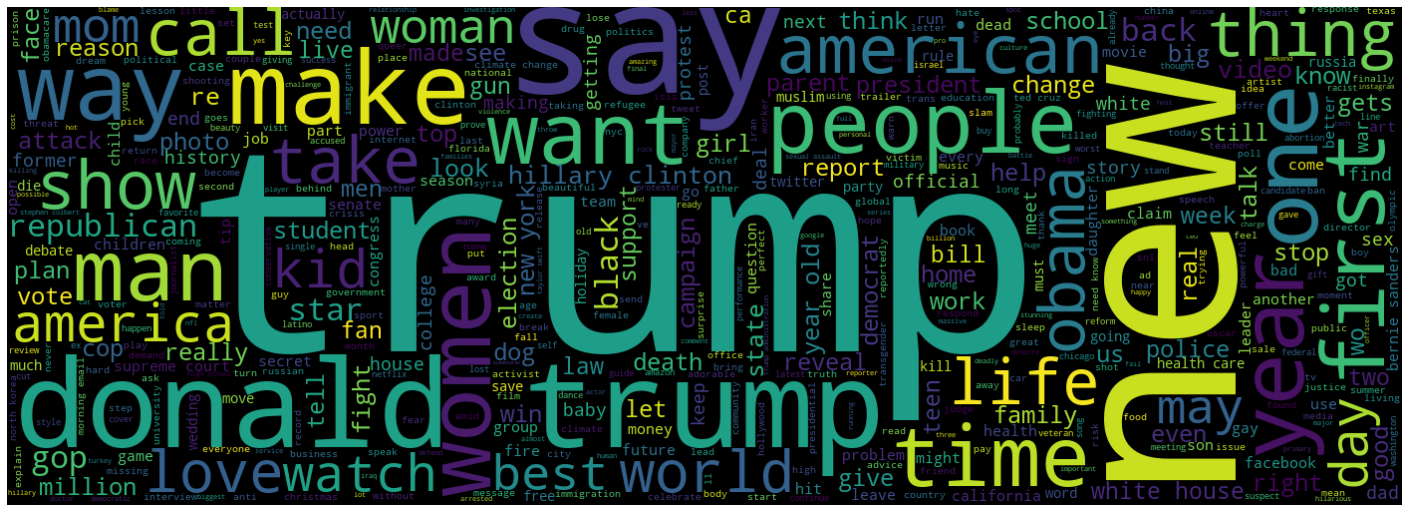

In [15]:
from wordcloud import WordCloud

plt.figure(figsize=(25,25))
plt.axis("off")
wordcloud = WordCloud(max_words=500, width=1400, height=500).generate(" ".join(news_headlines[news_headlines.is_sarcastic==0].headline_cleaned))
plt.imshow(wordcloud, interpolation='bilinear')

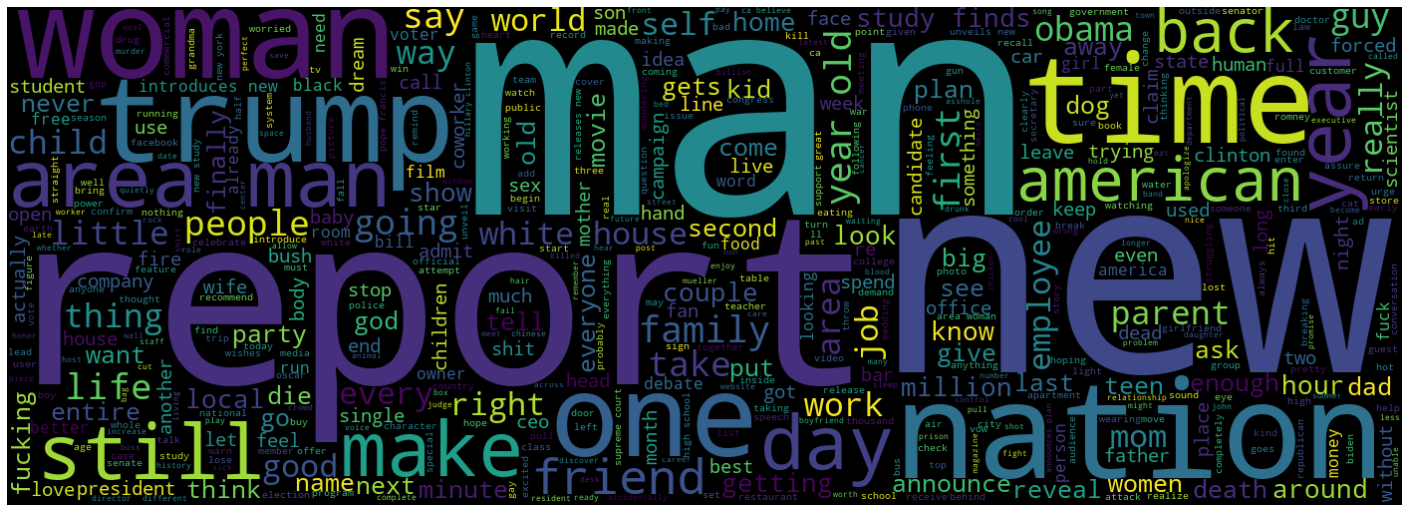

In [16]:
plt.figure(figsize=(25,25))
plt.axis("off")
wordcloud = WordCloud(max_words=500, width=1400, height=500).generate(" ".join(news_headlines[news_headlines.is_sarcastic==1].headline_cleaned))
plt.imshow(wordcloud, interpolation='bilinear')

In [17]:
from nltk.util import ngrams

# riga dopo dentro la funzione
senteces = (news_headlines[news_headlines.is_sarcastic==1].headline_cleaned).tolist()

bigrams = []
for sentece in senteces:
    bigrams.extend(list(ngrams(nltk.word_tokenize(sentece), 2)))

bigrams = pd.Series(bigrams).value_counts()
bigrams = pd.DataFrame(bigrams)

bigrams['bigram'] = bigrams.index
bigrams['bigram'] = bigrams.apply(lambda x: '('+x['bigram'][0]+', '+x['bigram'][1]+')', axis=1)
bigrams

,0,bigram
"(area, man)",263,"(area, man)"
"(white, house)",125,"(white, house)"
"(study, finds)",123,"(study, finds)"
"(introduces, new)",68,"(introduces, new)"
"(unveils, new)",58,"(unveils, new)"
...,...,...
"(randy, newman)",1,"(randy, newman)"
"(proud, tradition)",1,"(proud, tradition)"
"(entry, bar)",1,"(entry, bar)"
"(public, air)",1,"(public, air)"


In [18]:
import plotly.offline as pyoff
import plotly.graph_objs as go

# sulle x il nome della var
# color in base al sarcasmo
# concatenare nel titolo e nell'asse delle x il nome della var
plot_data = [
    go.Bar(
        x=bigrams['bigram'][:25],
        y=bigrams[0],
        marker = dict(
            color = 'Red'
        )
    )
]

plot_layout = go.Layout(
        title='Top 25 Sarcastic bi-grams',
        yaxis_title='Count',
        xaxis_title='bi-gram',
        plot_bgcolor='rgba(0,0,0,0)'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

## Word2Vec

In [19]:
import functools
import operator

words = functools.reduce(operator.iconcat, headline_cleaned, [])
len(words)
len(set(words))

30461

In [20]:
import gensim

embedding_dim = 100
w2v_model = gensim.models.Word2Vec(sentences=headline_cleaned, size=embedding_dim, window=5, min_count=1)

In [21]:
len(w2v_model.wv.vocab)

30461

In [22]:
# https://groups.google.com/g/gensim/c/gfOuXGzvsA8?pli=1
# https://stackoverflow.com/questions/21979970/how-to-use-word2vec-to-calculate-the-similarity-distance-by-giving-2-words
from scipy.spatial.distance import cdist

_ = {word: idx for (idx, word) in enumerate(w2v_model.wv.index2word)}
#similarity = 1 - cdist(w2v_model.wv.syn0, w2v_model.wv.syn0, metric='cosine')

In [50]:
w2v_features = []
w2v_features_target = []
target = -1
for sentence in headline_cleaned:
    target += 1
    current_sentence = np.array(sentence)
    similarity_matrix = np.zeros((len(current_sentence), len(current_sentence)))
    if len(current_sentence) > 1:
      for i in range(len(current_sentence)):
        for j in range(len(current_sentence)):
          if i <= j:
            similarity_matrix[i, j] = w2v_model.similarity(current_sentence[i], current_sentence[j])          
          else:
            similarity_matrix[i, j] = similarity_matrix[j, i]
      similarity_array = np.asarray(similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)])
      w2v_features.append([similarity_array])
      #w2v_features.append([min(similarity_array), max(similarity_array)])
      w2v_features_target.append(news_headlines.is_sarcastic[target])

print(w2v_features[:5])
print(w2v_features_target[:5])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning:

Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).



[[array([0.46276084, 0.46179926, 0.4121719 , 0.46223167, 0.46256265,
       0.46244019, 0.99704289, 0.98127133, 0.99870431, 0.99976951,
       0.99955493, 0.97701496, 0.99554491, 0.99707437, 0.99695897,
       0.98104167, 0.98104054, 0.98138493, 0.99871445, 0.99862969,
       0.99949068])], [array([0.96303946, 0.97010434, 0.96655762, 0.96985388, 0.96896976,
       0.97000593, 0.96892279, 0.96883088, 0.96733111, 0.99701166,
       0.99620789, 0.99709994, 0.99725068, 0.99692065, 0.99661398,
       0.99666405, 0.99608606, 0.99828905, 0.99972302, 0.99931228,
       0.99952525, 0.99942964, 0.99897909, 0.99851739, 0.99838191,
       0.99765539, 0.99830753, 0.99818015, 0.99745286, 0.99737549,
       0.99934304, 0.99968481, 0.99944788, 0.99939048, 0.99879444,
       0.99916232, 0.99889278, 0.99902105, 0.99844754, 0.9992348 ,
       0.99903482, 0.99852532, 0.99886602, 0.99809515, 0.9981699 ])], [array([0.91157144, 0.99948663, 0.78254586, 0.99954253, 0.99917412,
       0.91015816, 0.6929664 , 0.

In [57]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(w2v_features, w2v_features_target, test_size=0.3, random_state=109) # 70% training and 30% test

In [58]:
from sklearn import svm

clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)

ValueError: ignored

In [ ]:
from sklearn import metrics

y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [ ]:
del model

In [ ]:
from keras.preprocessing import text, sequence

tokenizer = text.Tokenizer(filters = "")
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(headline_cleaned)
x = sequence.pad_sequences(tokenized_train, maxlen = 20)
# set diff
x.shape

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
weight_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
  weight_matrix[i] = w2v_model[word] 

weight_matrix

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense, Dropout, Convolution1D
import tensorflow as tf

model = Sequential()

model.add(Embedding(vocab_size, output_dim=embedding_dim, input_length=20, trainable=False))

model.add(Bidirectional(LSTM(units=128 , recurrent_dropout=0.3, dropout=0.3, return_sequences=True)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['acc'])

In [ ]:
model.summary()

In [ ]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
X_train, X_test, y_train, y_test = train_test_split(x, news_headlines.is_sarcastic , test_size = 0.3 , random_state = 0) 

In [ ]:
X_train.shape
y_train.shape

In [ ]:
history = model.fit(X_train, y_train, batch_size=128, validation_data=(X_test, y_test), epochs=3)

In [ ]:
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100)

In [ ]:
weight_matrix.shape